### Environment Setup

In [1]:

# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import scanpy as sc
import liana as li
import decoupler as dc

import session_info



In [2]:
# R dependencies
import anndata2ri  # conversion
import rpy2
from rpy2.robjects import r  # running R in python
import random

anndata2ri.activate() 

%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: C:\Program Files\R\R-4.2.2
Default options to initialize R: rpy2, --quiet, --no-save
C:\Users\beatr\AppData\Local\Temp\ipykernel_8640\4213043727.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
C:\Users\beatr\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.


In [3]:
# import cellphonedb method via liana
from liana.method import cellphonedb

In [4]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning messages:
1: package 'ggplot2' was built under R version 4.2.3 
2: package 'tidyr' was built under R version 4.2.3 
3: package 'dplyr' was built under R version 4.2.3 
4: package 'purrr' was built under R version 4.2.3 
5: package 'tibble' was built under R version 4.2.3 


In [5]:
# figure settings
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor="white")
sc.set_figure_params(figsize=(5, 5))




### Upload data

In [6]:
# Read Object
r('obj = readRDS("MERGED_NEW_ANNOTATION.rds")')

# convert Seurat to SCE
adata = r('Seurat::as.SingleCellExperiment(obj)')



## Supervised Annotation

### Analysis

In [7]:
adata.obs["majority_voting"].cat.categories

AttributeError: Can only use .cat accessor with a 'category' dtype

C:\Users\beatr\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
C:\Users\beatr\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


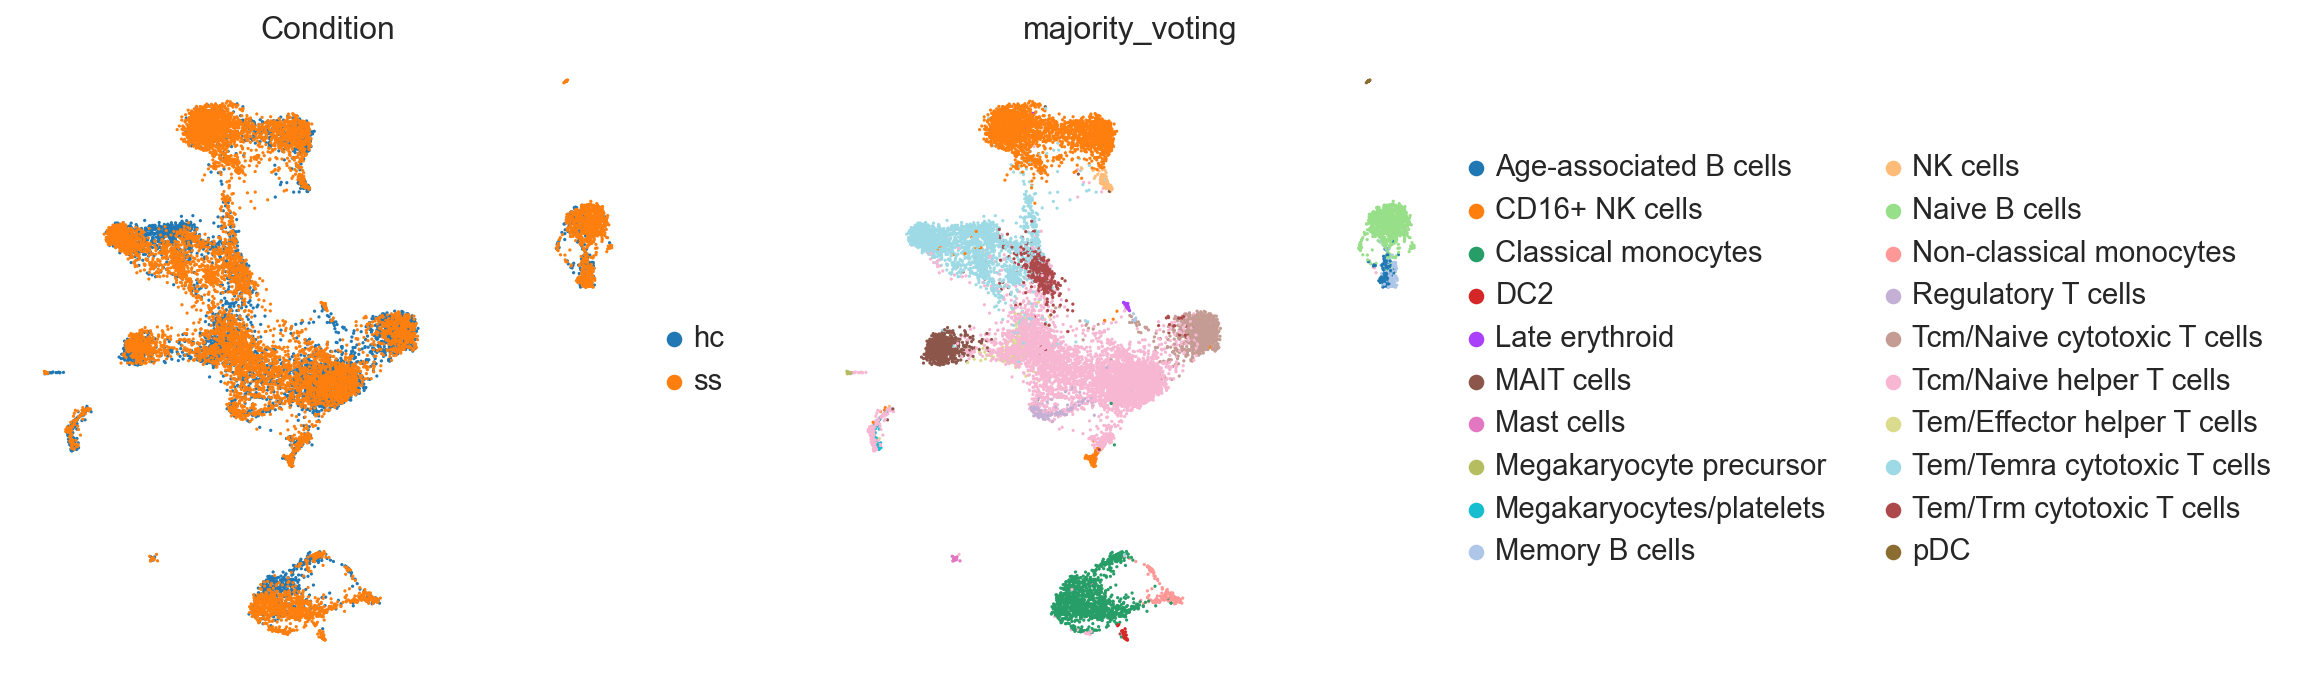

In [26]:
sc.pl.umap(adata, color=['Condition', 'majority_voting'], frameon=False)

#### Ligand - receptor inference

In [27]:
adata_ss = adata[adata.obs["Condition"] == "hc"].copy()
adata_ss

AnnData object with n_obs × n_vars = 4827 × 71823
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd', 'iscell_ed', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'Ident', 'Condition', 'unintegrated_clusters', 'RNA_snn_res.1', 'merged_idents', 'predicted_labels', 'over_clustering', 'majority_voting', 'ident'
    uns: 'Condition_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'UMAP.UNINTEGRATED', 'INTEGRATED.CCA', 'X_umap'
    layers: 'logcounts'

In [28]:
cellphonedb(
    adata_ss, groupby="majority_voting", use_raw=False, return_all_lrs=True, verbose=True
)

Using `.X`!
C:\Users\beatr\anaconda3\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
48961 features of mat are empty, they will be removed.
C:\Users\beatr\anaconda3\lib\site-packages\liana\method\_pipe_utils\_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
The following cell identities were excluded: Late erythroid
Using resource `consensus`.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 4826 samples and 22862 features


100%|██████████| 1000/1000 [00:07<00:00, 128.90it/s]


In [29]:
data = adata_ss.uns["liana_res"]
data['interaction'] = data['ligand_complex'] + '-' + data['receptor_complex']
data.head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
170039    APP            APP     12.142858      1.000000     CD74   
170040   COPA           COPA      1.714286      1.000000     CD74   
155736   COPA           COPA      0.875000      0.562500     CD74   
129512   COPA           COPA      0.866667      0.600000     CD74   
153352   COPA           COPA      0.745098      0.470588     CD74   

       receptor_complex  receptor_means  receptor_props  \
170039             CD74      285.833344             1.0   
170040             CD74      285.833344             1.0   
155736             CD74      285.833344             1.0   
129512             CD74      285.833344             1.0   
153352             CD74      285.833344             1.0   

                         source target  lrs_to_keep    lr_means  \
170039                      pDC    DC2         True  148.988098   
170040                      pDC    DC2         True  143.773819   
155736       Regulatory T cells    DC2         True  143.354172   
129512   Age-associated B cells    DC2         True  143.350006   
153352  Non-classical monocytes    DC2         True  143.289215   

        cellphone_pvals interaction  
170039              0.0    APP-CD74  
170040              0.0   COPA-CD74  
155736              0.0   COPA-CD74  
129512              0.0   COPA-CD74  
153352              0.0   COPA-CD74

In [46]:
interactions = ['EFNB1-ERBB2',
 'TNFSF4-TNFRSF4',
 'SERTAD1-AR',
 'HBEGF-CD9',
 'IL15RA-AXL',
 'SPINT1-ST14',
 'SEMA4B-DCBLD2',
 'APP-NCSTN',
 'PLTP-ABCA1',
 'ADAM9-ITGA6',
 'POMC-VIPR1',
 'LIN7C-ABCA1',
 'EFNB1-EPHA4',
 'HBEGF-CD82',
 'ADAM17-NOTCH1',
 'COL4A4-CD93',
 'TNFSF12-CD163',
 'ANXA2-ROBO4',
 'ARF1-INSR',
 'SEMA4A-PLXND1',
 'POMC-ADRB2',
 'TXLNA-STX4',
 'CD40LG-ITGAM_ITGB2',
 'NECTIN2-CD226',
 'F8-LDLR',
 'F8-ASGR2',
 'GAS6-AXL',
 'SEMA4D-ERBB2',
 'ADAM17-RHBDF2',
 'TNFSF10-TNFRSF10B']

In [ ]:
interactions = ['EFNB1-EPHA4',
 'EGF-PLD2',
 'IL15RA-AXL',
 'PROS1-AXL',
 'EFNA1-EPHA4',
 'EGF-AXL',
 'EFNB1-ERBB2',
 'EFNA4-EPHA4',
 'SERTAD1-AR',
 'EGF-LDLR',
 'KITLG-EPOR',
 'CCL28-ADRA2A',
 'GSTM2-RYR2',
 'TXLNA-STX3',
 'FAM3C-ADGRG5',
 'POMC-ADRA2A',
 'BMP6-ACVR1_BMPR2',
 'PTGS2-PTGDR2',
 'POMC-VIPR1',
 'COL4A4-CD93',
 'PLTP-ABCA1',
 'APP-ADRA2A',
 'TXLNA-STX4',
 'SPINT1-ST14',
 'LIN7C-ABCA1',
 'ADAM17-NOTCH1',
 'ADAM17-RHBDF2',
 'HBEGF-CD9',
 'ANXA2-ROBO4',
 'ADAM9-ITGA6']

In [47]:
adata_ss_filter_sa = data.query('interaction in @interactions')
adata_ss_filter_sa.head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
170066    APP            APP     12.142858           1.0    NCSTN   
770834    APP            APP     12.142858           1.0    NCSTN   
427538    APP            APP     12.142858           1.0    NCSTN   
127154    APP            APP     12.142858           1.0    NCSTN   
470450    APP            APP     12.142858           1.0    NCSTN   

       receptor_complex  receptor_means  receptor_props source  \
170066            NCSTN        0.500000        0.500000    pDC   
770834            NCSTN        0.285714        0.285714    pDC   
427538            NCSTN        0.210191        0.152866    pDC   
127154            NCSTN        0.199571        0.171674    pDC   
470450            NCSTN        0.196078        0.117647    pDC   

                         target  lrs_to_keep  lr_means  cellphone_pvals  \
170066                      DC2         True  6.321429              0.0   
770834                      pDC         True  6.214286              0.0   
427538            Naive B cells         True  6.176524              0.0   
127154      Classical monocytes         True  6.171214              0.0   
470450  Non-classical monocytes         True  6.169468              0.0   

       interaction  
170066   APP-NCSTN  
770834   APP-NCSTN  
427538   APP-NCSTN  
127154   APP-NCSTN  
470450   APP-NCSTN

In [48]:
lig_com_sa = adata_ss_filter_sa['ligand_complex']
rec_comp_sa = adata_ss_filter_sa['receptor_complex']
mask = adata_ss_filter_sa['interaction'].isin(interactions)
lig_com_sa = list(lig_com_sa[mask.values].unique())
rec_comp_sa = list(rec_comp_sa[mask.values].unique())
cell_types_sa = ['Age-associated B cells', 'CD16+ NK cells', 'Classical monocytes', 'DC2', 'MAIT cells', 'Mast cells','Megakaryocytes/platelets', 'Memory B cells', 'Naive B cells', 'NK cells', 'Non-classical monocytes', 'pDC', 'Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells']



#### Visual Exploration

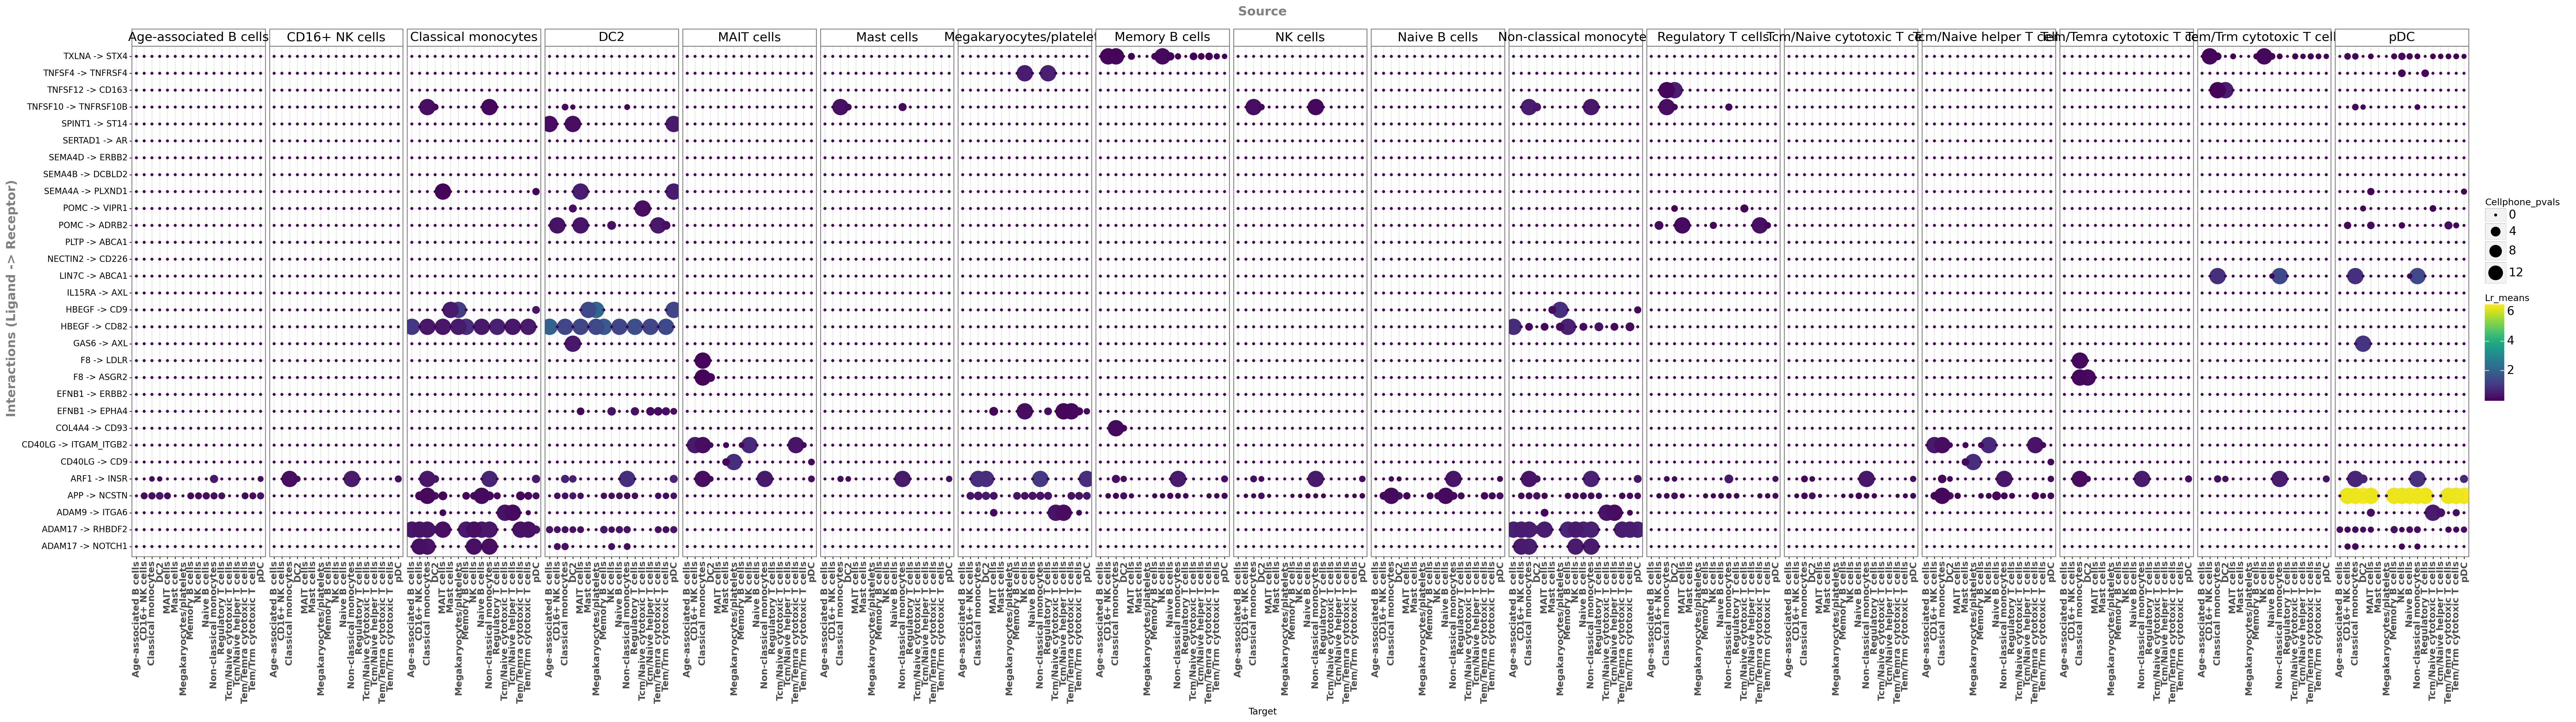

<ggplot: (154690317285)>

In [49]:
# Dotplot with all cell types as source and target
li.pl.dotplot(
    adata=adata_ss,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,
    source_labels=cell_types_sa,
    target_labels=cell_types_sa,
    ligand_complex=lig_com_sa,
    receptor_complex=rec_comp_sa,
    orderby='lr_means',
    orderby_ascending=False,
    figure_size=(50, 11),
    size_range=(1, 10)
)

In [50]:
# See how much cell types appear in source and target
table1 = adata_ss_filter_sa['source'].value_counts()
table2 = adata_ss_filter_sa['target'].value_counts()
cells = pd.merge(table1, table2, left_index= True, right_index= True)
cells['Diff'] = cells['source'] - cells['target']
cells.index.name = 'Cell Type'
cells['Cell Type'] = cells.index
cells

source  target  Diff                    Cell Type
Cell Type                                                                     
pDC                             522     522     0                          pDC
DC2                             522     522     0                          DC2
Tcm/Naive cytotoxic T cells     522     522     0  Tcm/Naive cytotoxic T cells
Age-associated B cells          522     522     0       Age-associated B cells
NK cells                        522     522     0                     NK cells
Mast cells                      522     522     0                   Mast cells
Tem/Temra cytotoxic T cells     522     522     0  Tem/Temra cytotoxic T cells
CD16+ NK cells                  522     522     0               CD16+ NK cells
Memory B cells                  522     522     0               Memory B cells
Regulatory T cells              522     522     0           Regulatory T cells
MAIT cells                      522     522     0                   MAIT cells
Tcm/Naive helper T cells        522     522     0     Tcm/Naive helper T cells
Tem/Effector helper T cells     522     522     0  Tem/Effector helper T cells
Non-classical monocytes         522     522     0      Non-classical monocytes
Megakaryocytes/platelets        522     522     0     Megakaryocytes/platelets
Classical monocytes             522     522     0          Classical monocytes
Tem/Trm cytotoxic T cells       522     522     0    Tem/Trm cytotoxic T cells
Naive B cells                   522     522     0                Naive B cells

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'pDC'),
  Text(1, 0, 'DC2'),
  Text(2, 0, 'Tem/Trm cytotoxic T cells'),
  Text(3, 0, 'Classical monocytes'),
  Text(4, 0, 'Megakaryocytes/platelets'),
  Text(5, 0, 'Non-classical monocytes'),
  Text(6, 0, 'Tem/Effector helper T cells'),
  Text(7, 0, 'Tcm/Naive helper T cells'),
  Text(8, 0, 'MAIT cells'),
  Text(9, 0, 'Regulatory T cells'),
  Text(10, 0, 'Memory B cells'),
  Text(11, 0, 'CD16+ NK cells'),
  Text(12, 0, 'Tem/Temra cytotoxic T cells'),
  Text(13, 0, 'Mast cells'),
  Text(14, 0, 'NK cells'),
  Text(15, 0, 'Age-associated B cells'),
  Text(16, 0, 'Tcm/Naive cytotoxic T cells'),
  Text(17, 0, 'Naive B cells')])

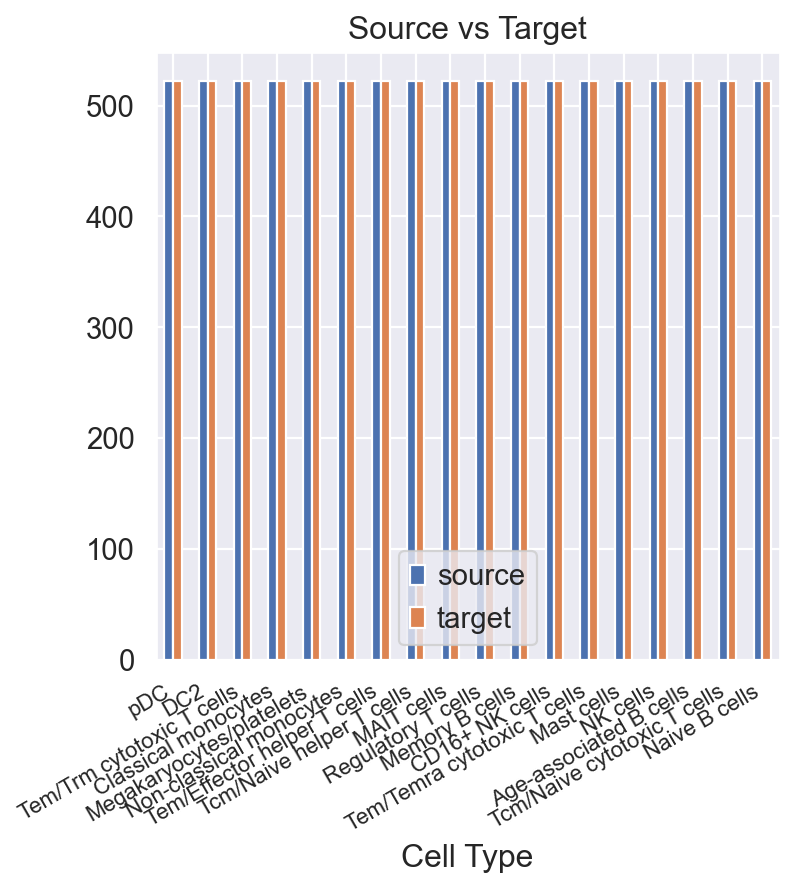

In [51]:
# Plot cell types counts in source and target
cells = cells.sort_values('source', ascending=False)
cells.plot.bar(x = 'Cell Type', y = ['source', 'target'])
plt.title('Source vs Target')
plt.xticks(rotation=30, ha='right', fontsize = 10)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'pDC'),
  Text(1, 0, 'DC2'),
  Text(2, 0, 'Tcm/Naive cytotoxic T cells'),
  Text(3, 0, 'Age-associated B cells'),
  Text(4, 0, 'NK cells'),
  Text(5, 0, 'Mast cells'),
  Text(6, 0, 'Tem/Temra cytotoxic T cells'),
  Text(7, 0, 'CD16+ NK cells'),
  Text(8, 0, 'Memory B cells'),
  Text(9, 0, 'Regulatory T cells'),
  Text(10, 0, 'MAIT cells'),
  Text(11, 0, 'Tcm/Naive helper T cells'),
  Text(12, 0, 'Tem/Effector helper T cells'),
  Text(13, 0, 'Non-classical monocytes'),
  Text(14, 0, 'Megakaryocytes/platelets'),
  Text(15, 0, 'Classical monocytes'),
  Text(16, 0, 'Tem/Trm cytotoxic T cells'),
  Text(17, 0, 'Naive B cells')])

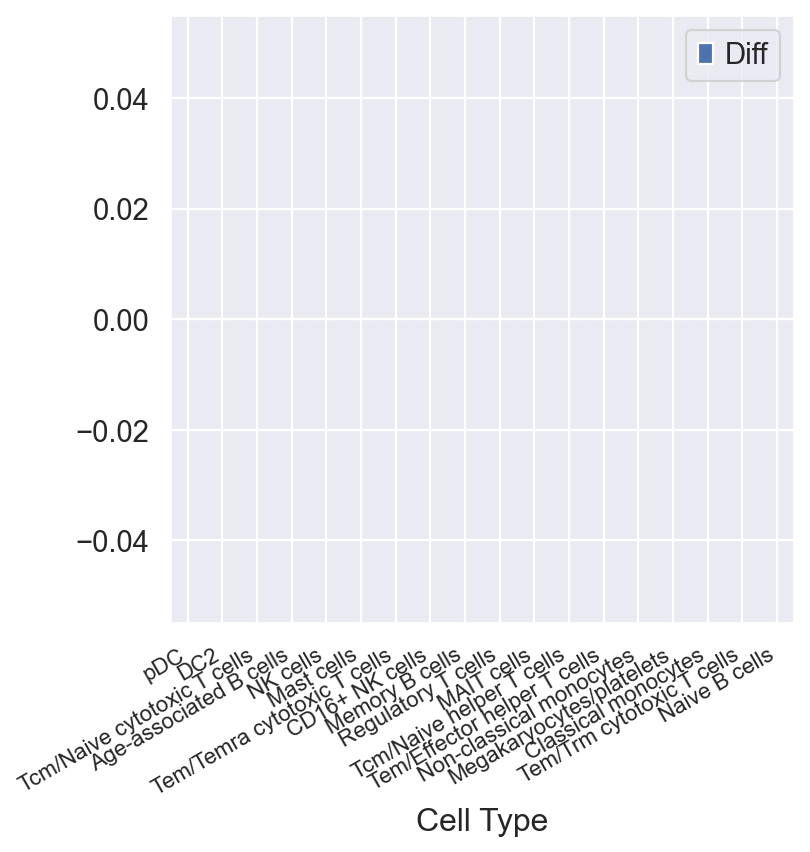

In [52]:
# Plot the difference in counts of Source and Target for each cell type
cells2 = cells.sort_values('Diff', ascending=False)
cells2.plot.bar(x = 'Cell Type', y = 'Diff')
plt.xticks(rotation=30, ha='right', fontsize=10)

In [53]:
# Get the gene markers
markers_sa = pd.read_table('Markers_SA.csv', sep=' ')
markers_sa.head()

p_val  avg_log2FC  pct.1  pct.2  p_val_adj                      cluster  \
0    0.0    3.273692  0.864  0.102        0.0  Tcm/Naive cytotoxic T cells   
1    0.0    3.108659  0.817  0.120        0.0  Tcm/Naive cytotoxic T cells   
2    0.0    4.232848  0.720  0.059        0.0  Tcm/Naive cytotoxic T cells   
3    0.0    1.491348  0.838  0.187        0.0  Tcm/Naive cytotoxic T cells   
4    0.0    1.948411  0.857  0.229        0.0  Tcm/Naive cytotoxic T cells   

        gene  
0       CD8B  
1      NELL2  
2  LINC02446  
3       CD8A  
4       LEF1

In [54]:
# Table with top ligands expression 
adata_ss_filter_sa = adata_ss_filter_sa.query('interaction in @interactions')
mask_sa = markers_sa['gene'].isin(adata_ss_filter_sa['ligand'].unique()[0:30])
markers_filter_sa = markers_sa[mask_sa]
# Matrix with ligands expression by cell type
matrix_sa = markers_filter_sa.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix_sa.shape

(23, 20)

[Text(1, 0.5, 'CD40LG'),
 Text(1, 1.5, 'TNFSF12'),
 Text(1, 2.5, 'SEMA4D'),
 Text(1, 3.5, 'SERTAD1'),
 Text(1, 4.5, 'HBEGF'),
 Text(1, 5.5, 'SEMA4A'),
 Text(1, 6.5, 'SPINT1'),
 Text(1, 7.5, 'ADAM9'),
 Text(1, 8.5, 'ARF1'),
 Text(1, 9.5, 'EFNB1'),
 Text(1, 10.5, 'TNFSF4'),
 Text(1, 11.5, 'APP'),
 Text(1, 12.5, 'GAS6'),
 Text(1, 13.5, 'COL4A4'),
 Text(1, 14.5, 'SEMA4B'),
 Text(1, 15.5, 'NECTIN2'),
 Text(1, 16.5, 'IL15RA'),
 Text(1, 17.5, 'TNFSF10'),
 Text(1, 18.5, 'PLTP'),
 Text(1, 19.5, 'POMC'),
 Text(1, 20.5, 'F8'),
 Text(1, 21.5, 'ADAM17'),
 Text(1, 22.5, 'TXLNA')]

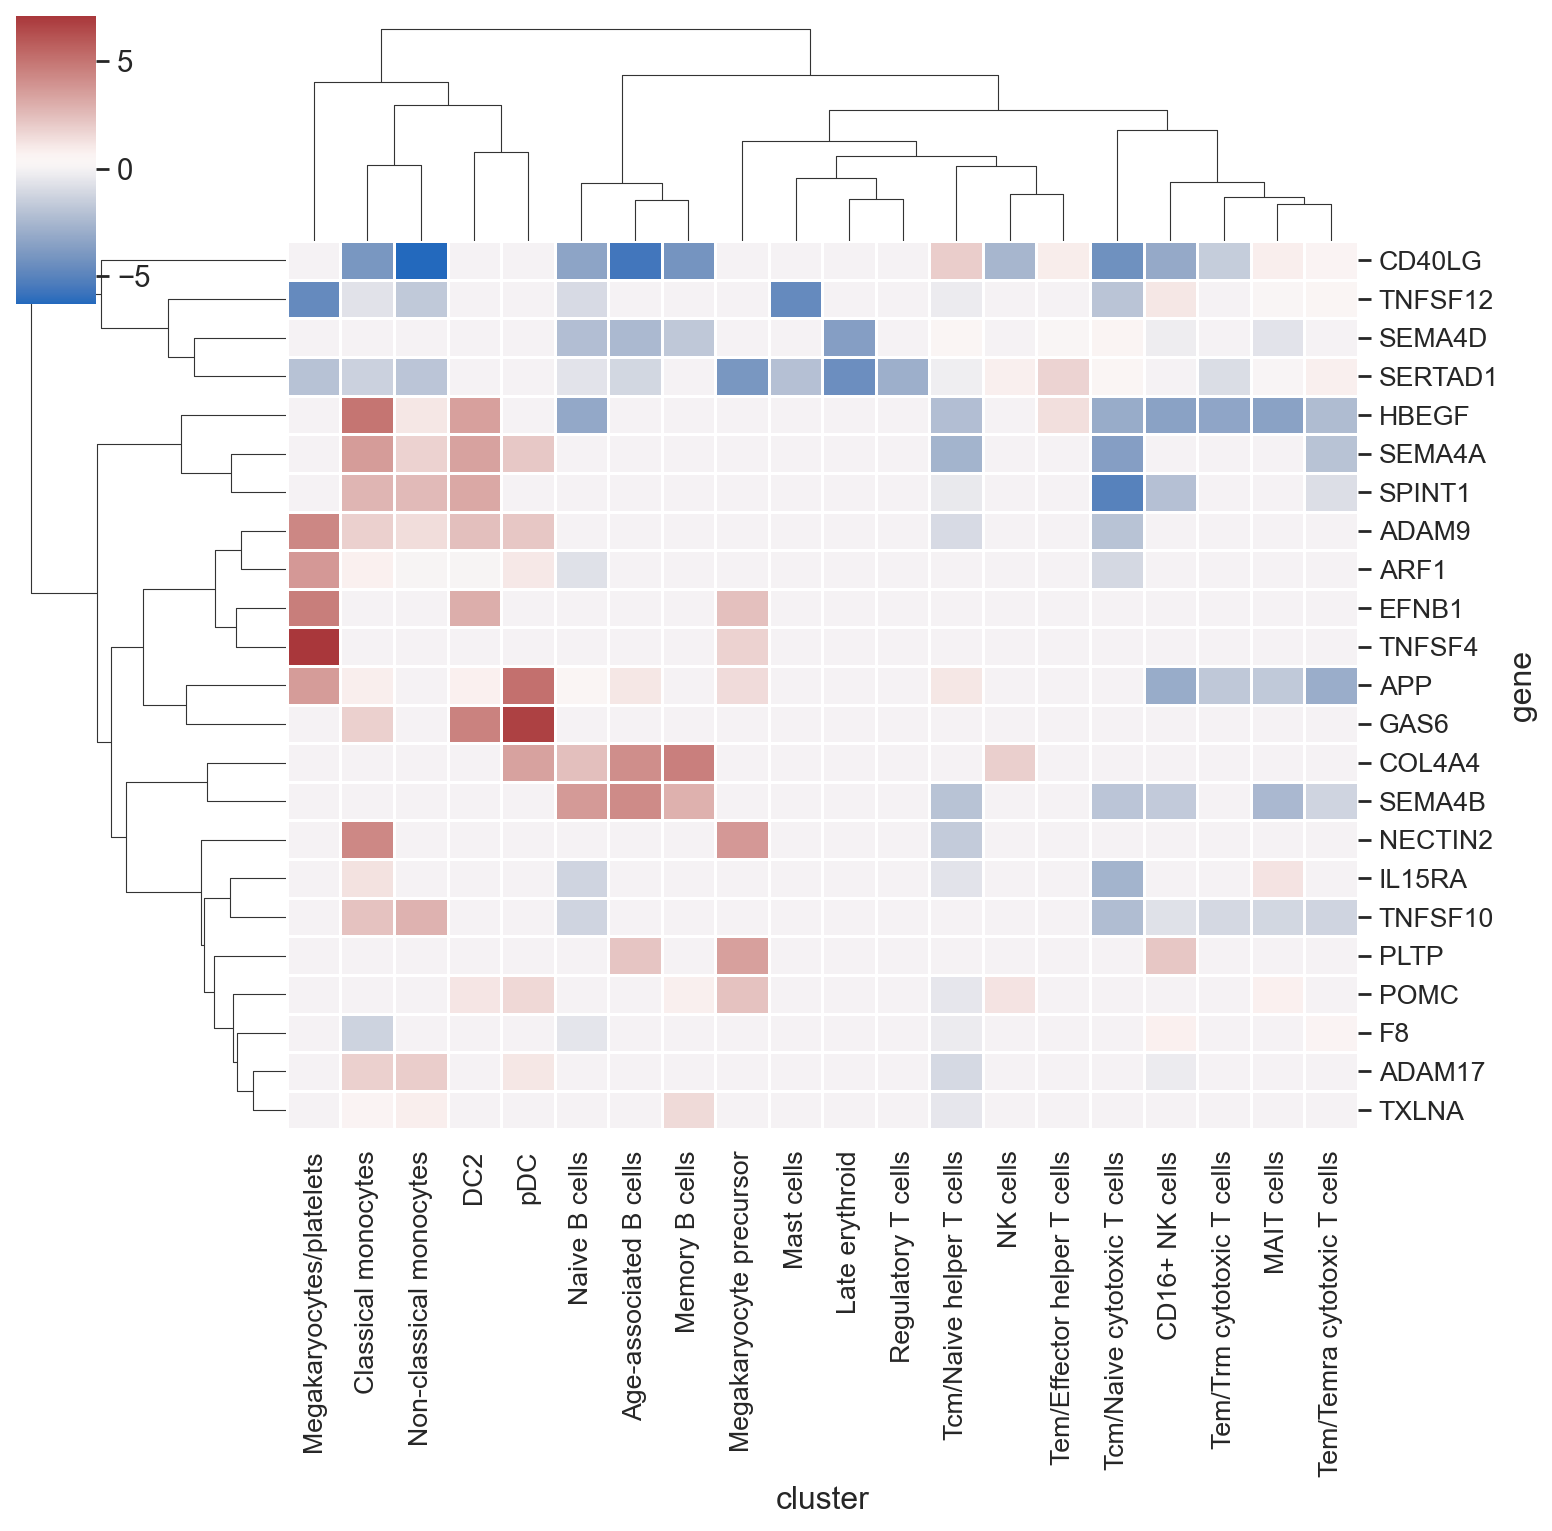

In [55]:
# Clustermap with ligands expression by cell type
sns.set(font_scale=1.2)
clustermap_sa = sns.clustermap(matrix_sa.fillna(0), cmap='vlag', annot=False, linewidths=.5, cbar_kws={"shrink": 0.7}, method="ward")
clustermap_sa.ax_heatmap.set_xticklabels(clustermap_sa.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap_sa.ax_heatmap.set_yticklabels(clustermap_sa.ax_heatmap.get_yticklabels(), fontsize=12)

In [56]:
# Top receptors expression
mask_re_sa = markers_sa['gene'].isin(adata_ss_filter_sa['receptor'].unique()[0:30])
markers_filter_re_sa = markers_sa[mask_re_sa]

matrix_re_sa = markers_filter_re_sa.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix_re_sa.shape


(26, 19)

[Text(1, 0.5, 'ST14'),
 Text(1, 1.5, 'CD93'),
 Text(1, 2.5, 'ASGR2'),
 Text(1, 3.5, 'CD163'),
 Text(1, 4.5, 'ABCA1'),
 Text(1, 5.5, 'INSR'),
 Text(1, 6.5, 'AR'),
 Text(1, 7.5, 'AXL'),
 Text(1, 8.5, 'PLXND1'),
 Text(1, 9.5, 'RHBDF2'),
 Text(1, 10.5, 'NCSTN'),
 Text(1, 11.5, 'STX4'),
 Text(1, 12.5, 'TNFRSF10B'),
 Text(1, 13.5, 'LDLR'),
 Text(1, 14.5, 'NOTCH1'),
 Text(1, 15.5, 'CD9'),
 Text(1, 16.5, 'VIPR1'),
 Text(1, 17.5, 'CD82'),
 Text(1, 18.5, 'DCBLD2'),
 Text(1, 19.5, 'ADRB2'),
 Text(1, 20.5, 'ERBB2'),
 Text(1, 21.5, 'ITGAM'),
 Text(1, 22.5, 'EPHA4'),
 Text(1, 23.5, 'TNFRSF4'),
 Text(1, 24.5, 'CD226'),
 Text(1, 25.5, 'ITGA6')]

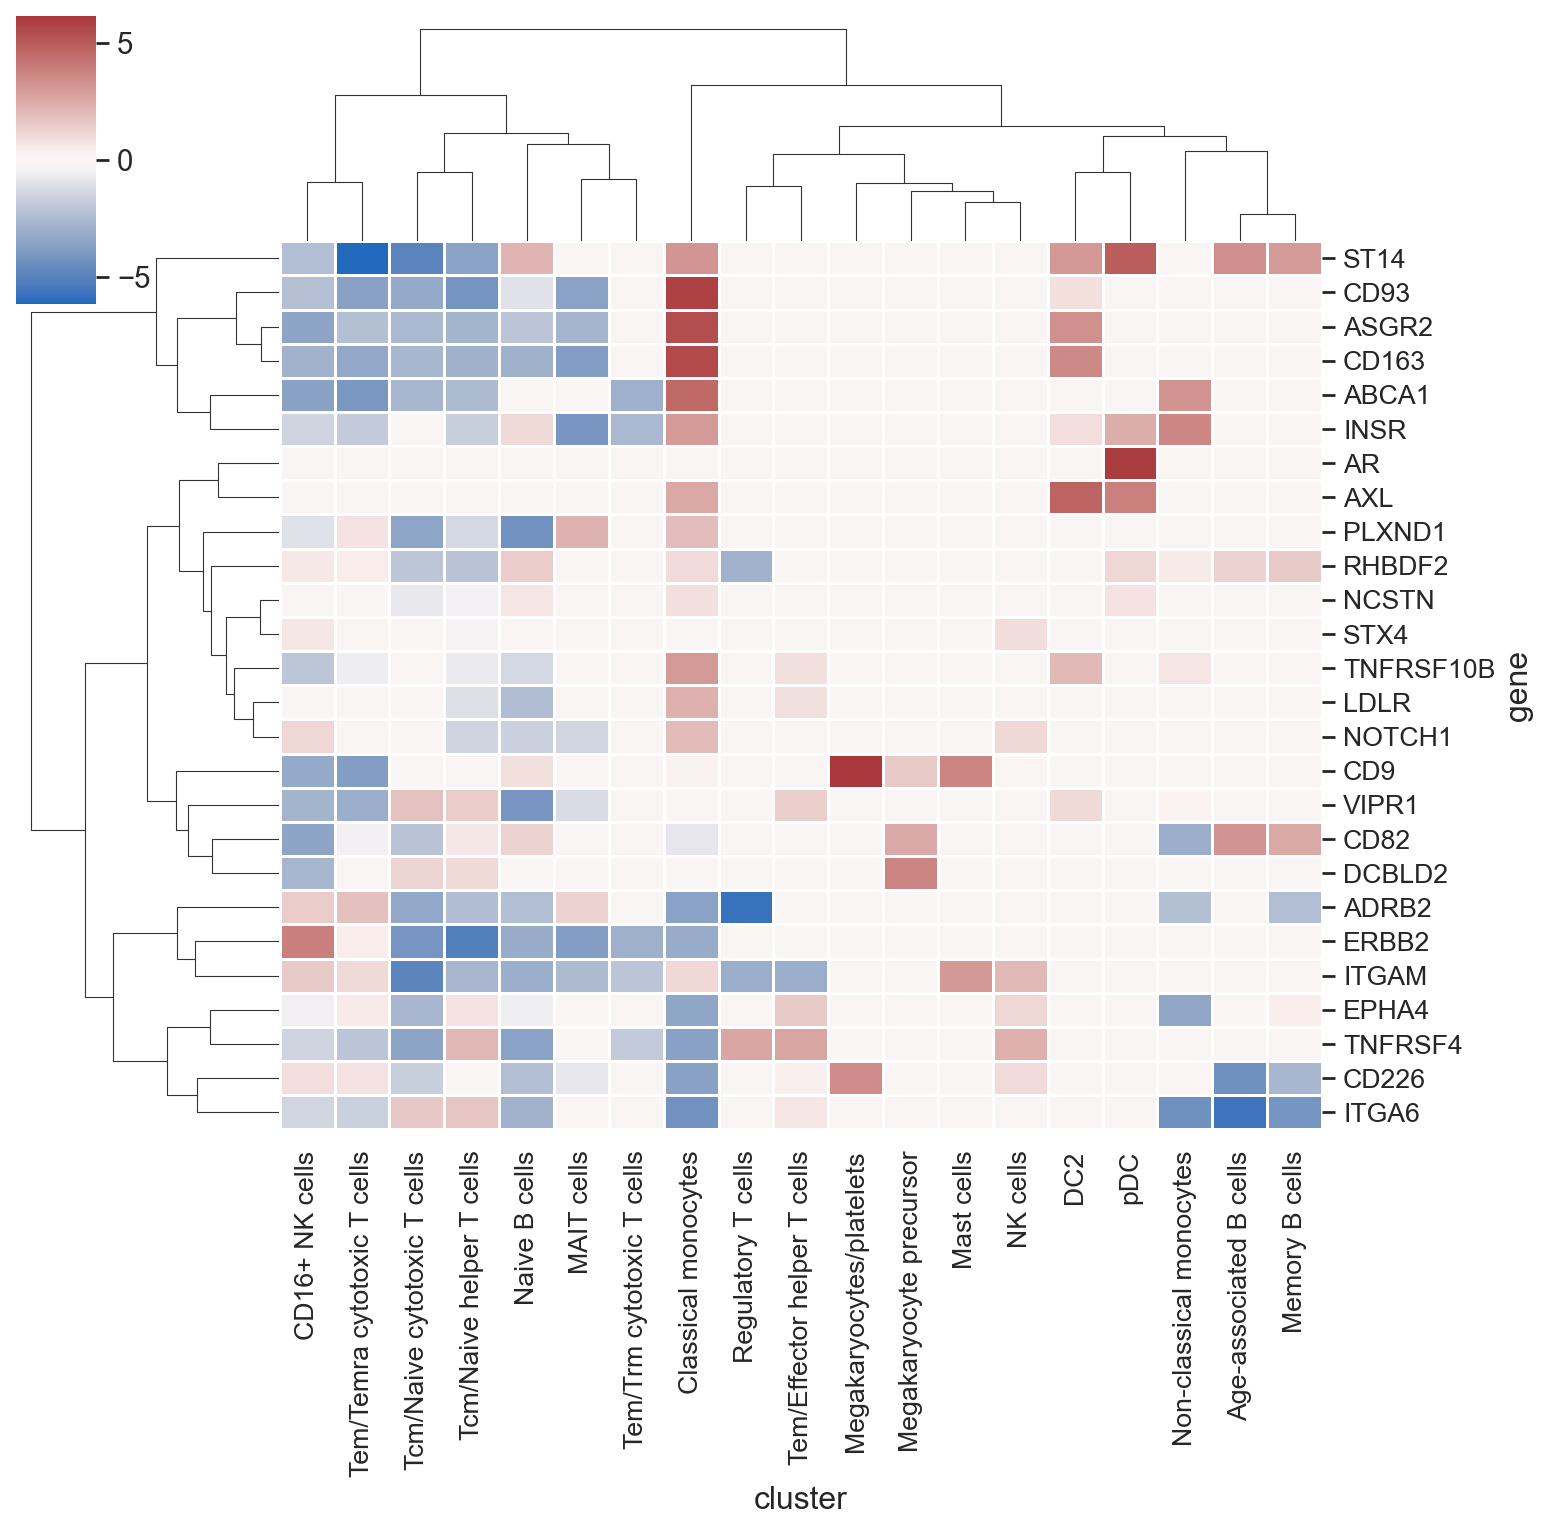

In [57]:
# Clustermap with top receptors expression by cell type
sns.set(font_scale=1.2)
clustermap_re_sa = sns.clustermap(matrix_re_sa.fillna(0), cmap='vlag', annot=False, linewidths=.5, cbar_kws={"shrink": 0.7}, method = 'ward')
clustermap_re_sa.ax_heatmap.set_xticklabels(clustermap_re_sa.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap_re_sa.ax_heatmap.set_yticklabels(clustermap_re_sa.ax_heatmap.get_yticklabels(), fontsize=12)

In [58]:
# Define cell types in source and target 
types = ['Classical monocytes', 'Non-classical monocytes', 'Naive B cells', 'Age-associated B cells', 'Memory B cells', 'DC2', 'pDC']


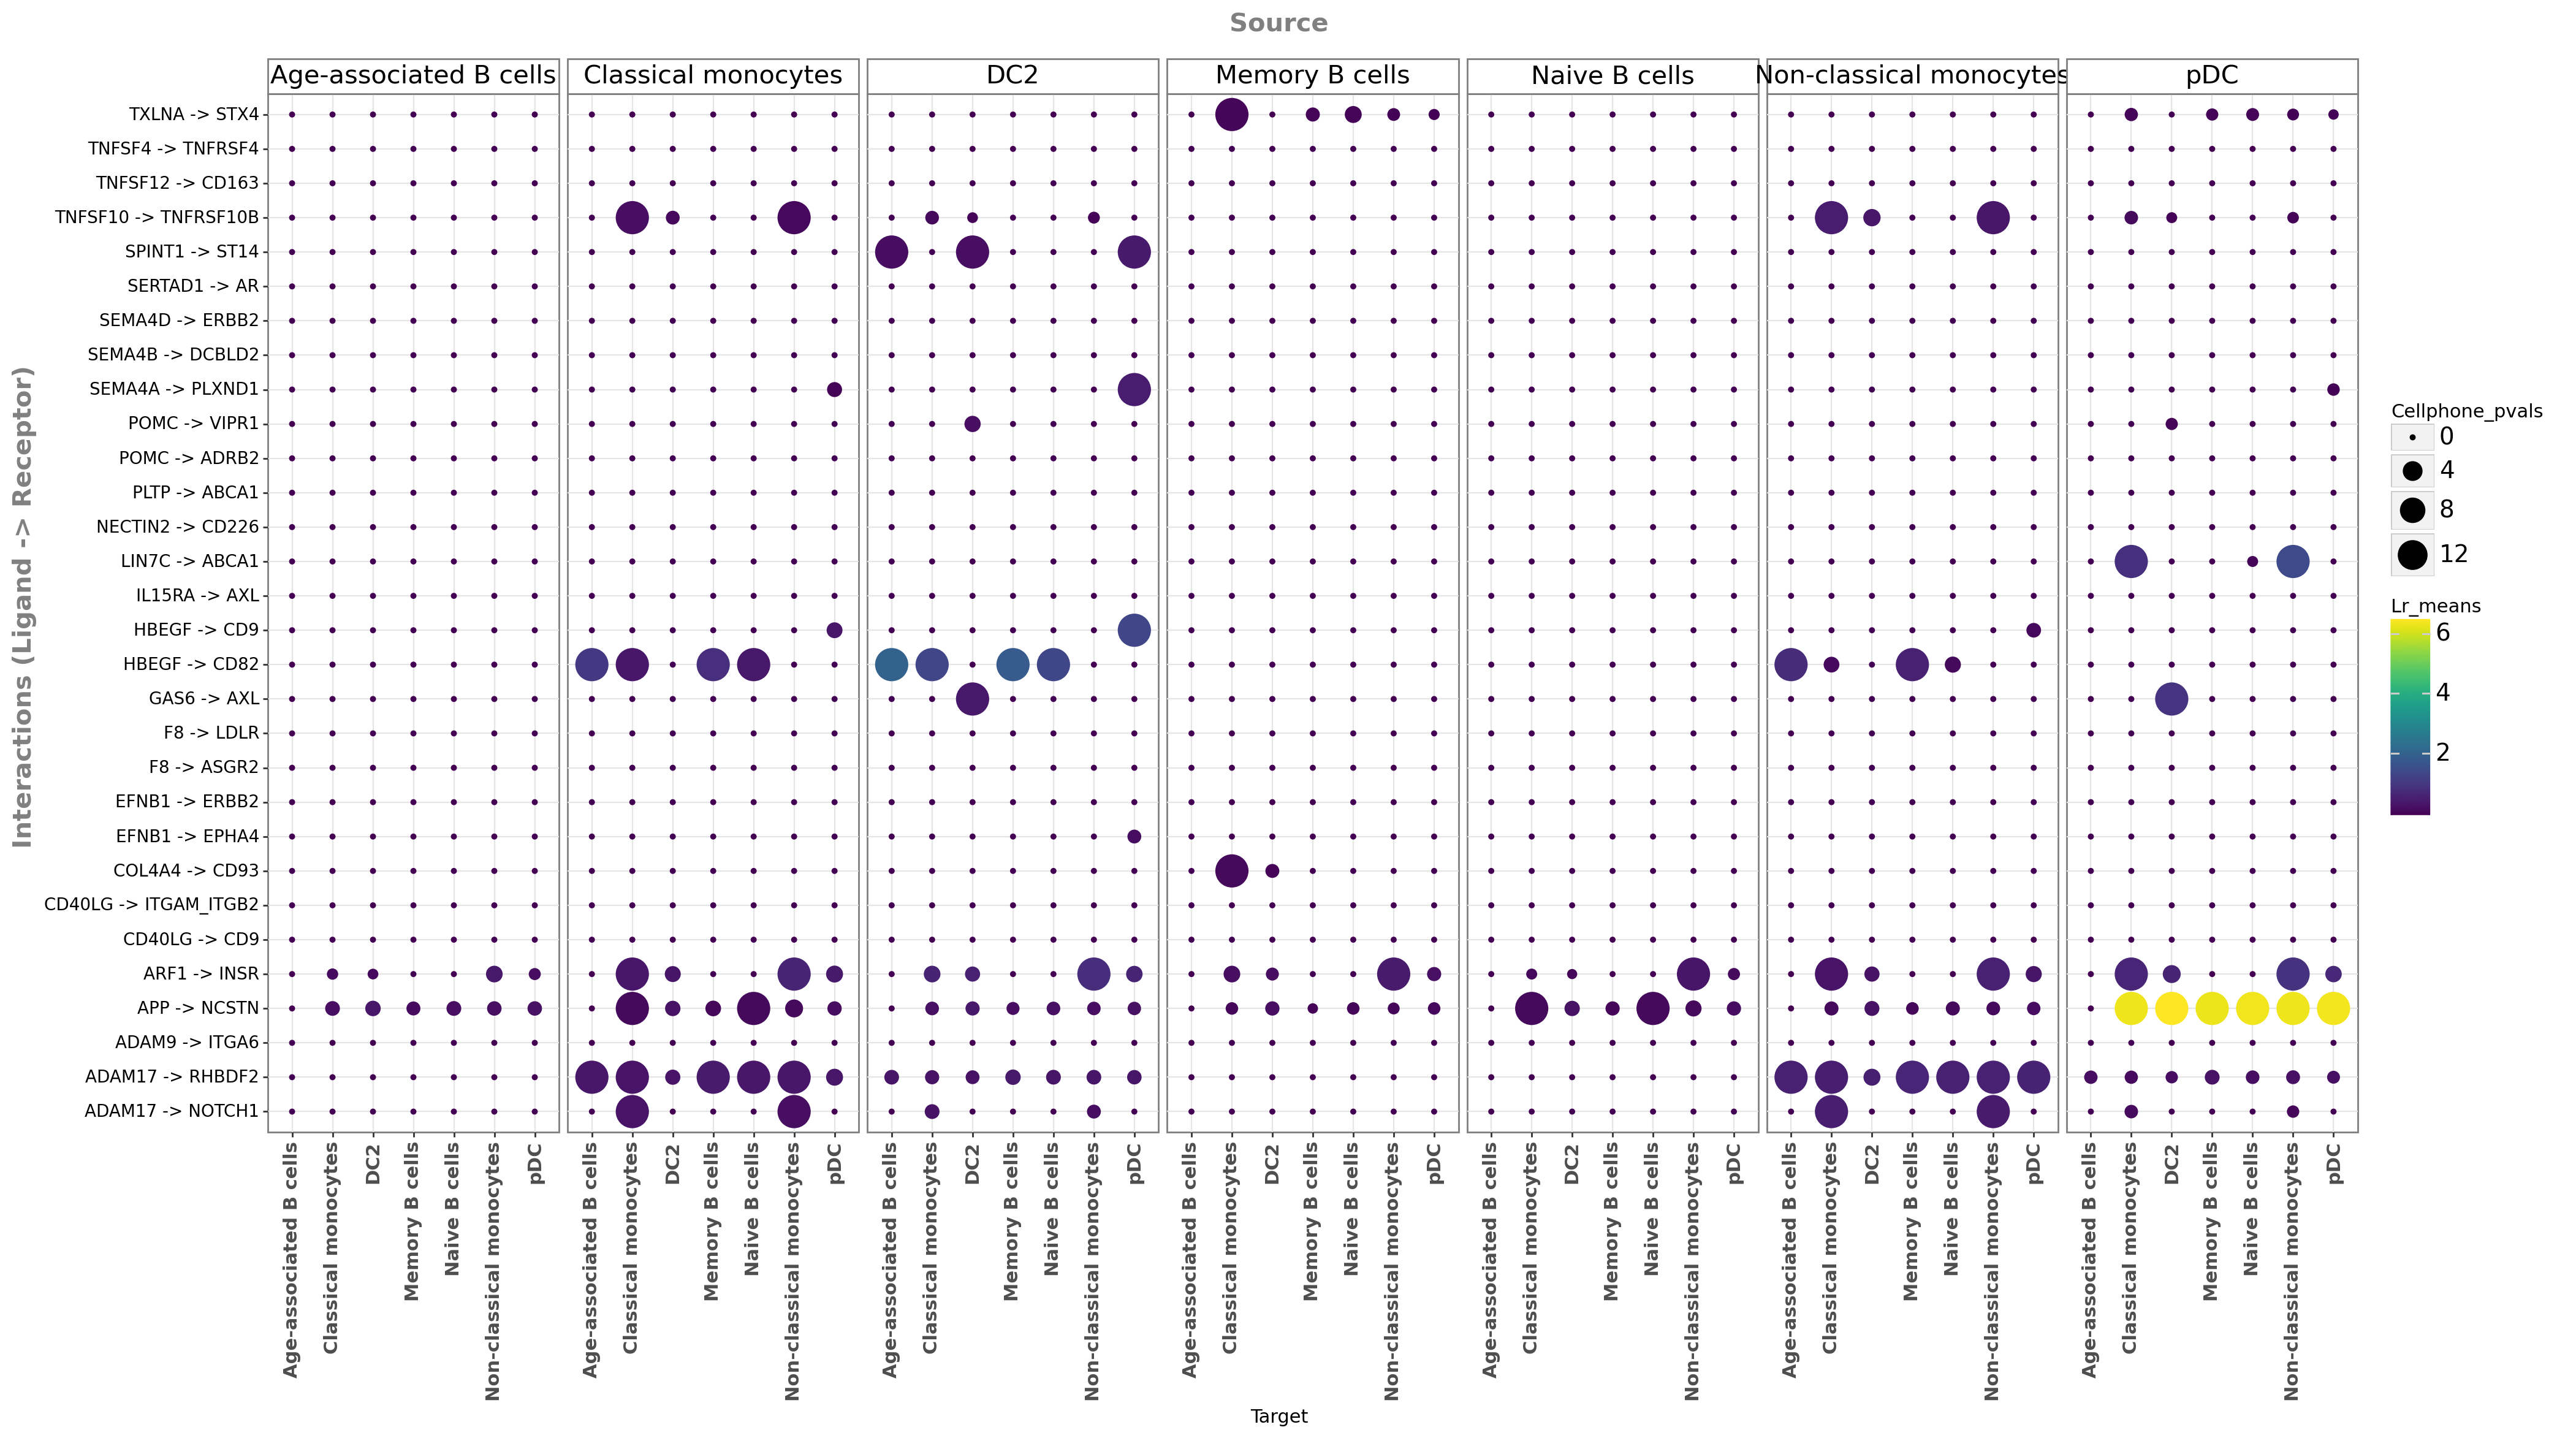

<ggplot: (153957989919)>

In [59]:
# Final dotplot with cell types defined as source and target
li.pl.dotplot(
    adata=adata_ss,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,
    source_labels= types,
    target_labels= types,
    ligand_complex=lig_com_sa,
    receptor_complex=rec_comp_sa,
    figure_size=(22, 11),
    size_range=(1, 10)
)

